In [1]:
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import torch
import seaborn as sns
from torch.distributions.utils import logits_to_probs

from sklearn import linear_model
import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import ClippedAdam

from src.utils import load_data

### Load data

In [2]:
X, y, k = load_data()
print(X.head())
X = X.values
y = y.values
print('X-shape: {}, y-shape: {}'.format(X.shape, y.shape)) 

   youth_pop_5to18  commute_priv_vehicle  med_hhincome  avg_ann_daily_traffic  \
0              894              0.634634         74837                 8682.0   
1             1158              0.494977         77991                16917.0   
2             1120              0.422405         32354                22712.0   
3              281              0.199795         34635               124767.0   
4             1998              0.286795         23423                10219.0   

   fragment_index  TotalPop   Men  Women  Hispanic  White  ...  Transit  Walk  \
0       -3.061385      5403  2659   2744      75.8    2.3  ...     38.6   2.9   
1       -2.915361      5915  2896   3019      62.7    3.6  ...     44.6   1.4   
2       -0.227456      5879  2558   3321      65.1    1.6  ...     45.5   8.6   
3        3.029461      2591  1206   1385      55.4    9.0  ...     63.9   3.0   
4        0.165237      8516  3301   5215      61.1    1.6  ...     68.2   4.3   

   OtherTransp  WorkAtHome

##### Prepare data for model.

In [3]:
# standardize input features
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std

##### Baseline linear regression

In [4]:
# Get indeces for dividing data into training and test set.
train_perc = 0.8 # percentage of training data
split_point = int(train_perc*len(y))
perm = np.random.permutation(len(y))
ix_train = perm[:split_point]
ix_test = perm[split_point:]

In [5]:
X_train = X[ix_train,:]
X_test = X[ix_test,:]
k_train = k[ix_train]
k_test = k[ix_test]
y_train = y[ix_train]
y_test = y[ix_test]
print("num train: %d" % len(y_train))
print("num test: %d" % len(y_test))

num train: 1676
num test: 419


In [6]:
# create and fit regression model
lreg = linear_model.LinearRegression()
lreg.fit(X_train, y_train)

# make predictions for test set
y_hat_lreg = lreg.predict(X_test)
print("first 5 predictions:", y_hat_lreg[:5])
print("first 5 true values:", y_test[:5])

# evaluate prediction accuracy
print("MSE:", sum((y_hat_lreg - y_test)**2)/len(y_hat_lreg))

first 5 predictions: [ 5.28284129  7.53448924  4.4561201  12.45471629  4.28264292]
first 5 true values: [ 6  5 13 42  2]
MSE: 35.90499430367748


In [7]:
# Test significance in our fit.
import statsmodels.api as sm

X2 = sm.add_constant(X_train)
ols = sm.OLS(y_train, X2)
ols = ols.fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                     24.49
Date:                Mon, 24 May 2021   Prob (F-statistic):          3.78e-121
Time:                        10:30:24   Log-Likelihood:                -5411.8
No. Observations:                1676   AIC:                         1.089e+04
Df Residuals:                    1641   BIC:                         1.108e+04
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.1293      0.151     53.768      0.0

So only a very few number of parameters are significant. The model is heavily driven by bias and x1.

Therefore, we assume that not all variables will be relevant to include in our hierarchical model. Therefore, we are only interested in keeping a number of the variables.
Let's try only keeping 8 features based on Least Angle Regression Selection (LARS):

In [8]:
from sklearn import linear_model

lars = linear_model.Lars(n_nonzero_coefs=8)
lars.fit(X_train, y_train)
x_include = lars.coef_ != 0
x_include = np.array([i for i, incl in enumerate(x_include) if incl])
print("Include ids: ", x_include)

Include ids:  [ 0  1  2  9 10 16 19 25]


In [9]:
X2 = sm.add_constant(X_train[:, x_include])
ols2 = sm.OLS(y_train, X2)
ols2 = ols2.fit()
print(ols2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.323
Model:                            OLS   Adj. R-squared:                  0.320
Method:                 Least Squares   F-statistic:                     99.51
Date:                Mon, 24 May 2021   Prob (F-statistic):          1.60e-135
Time:                        10:30:24   Log-Likelihood:                -5428.6
No. Observations:                1676   AIC:                         1.088e+04
Df Residuals:                    1667   BIC:                         1.092e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.1456      0.151     53.844      0.0

Notice that all variables might not still be significant, but this might change based on the train/test split. On could also use forward or backward feature selection for this matter.

In [10]:
# create and fit regression model
lreg = linear_model.LinearRegression()
lreg.fit(X_train[:, x_include], y_train)

# make predictions for test set
y_hat_lreg = lreg.predict(X_test[:, x_include])
print("first 5 predictions:", y_hat_lreg[:5])
print("first 5 true values:", y_test[:5])

# evaluate prediction accuracy
print("MSE:", sum((y_hat_lreg - y_test)**2)/len(y_hat_lreg))

first 5 predictions: [ 6.0854652   7.27722783  4.48067029 12.15602102  4.69986225]
first 5 true values: [ 6  5 13 42  2]
MSE: 35.3059614135835


### Redefine used variables

In [11]:
X_train = X_train[:, x_include]
X_test = X_test[:, x_include]

### Define model

**Generative Process**
<ol>
    <li> Draw parameter $r \sim \text{Gamma}(\alpha, \beta)$ . </li>
    <li> Draw parameter $\sigma \sim \text{HalfCauchy}(1)$. </li>
    <li> For each group $k \in \{1, \dots, K\}$ </li>
    <ol>
        <li> Draw linear coefficients $\beta_k \sim N(\beta|\textbf{0},\lambda\textbf{I})$</li>
    </ol>
    <li> For the i'th observation </li>
    <ol>
        <li> Draw $\psi_n \sim N(\psi_n | \beta_{k_n}^T\textbf{X}'_n+f_{\text{nnet}}(\textbf{X}^*_n), \sigma^2)$</li>
        <li> OR Draw $\psi_n \sim N(\psi_n | \beta_{k_n}^T\textbf{X}'_n, \sigma^2)$</li>
        <li> Compute $p_n$. </li>
        <li> Draw $y_n \sim \text{NB}(r, p_n)$</li>
    </ol>
</ol>

We could also try to fit an $r_k$ for each group.


In [12]:
def hierarchical_model(X, k, n_k, obs=None):
    
    # Number of observations
    N, n_feat = X.shape
    
    # Hyperparameters
    r_gamma1 = 2
    r_gamma2 = 2
    beta_mu = 0
    beta_sigma = 1

    # Draw parameters.
    r = pyro.sample("r", dist.Gamma(r_gamma1, r_gamma2).to_event())
    sigma = pyro.sample("sigma", dist.HalfCauchy(2).to_event())
    
    with pyro.plate("group", n_k):
        # Draw the parameters for each group
        beta = pyro.sample(
            "beta",
            dist.Normal(beta_mu*torch.ones(n_feat), beta_sigma*torch.ones(n_feat)).to_event()
        )
        
    with pyro.plate("data", N):
        psi_mu = torch.matmul(X, beta[k].transpose(0,1)).diag() # Pretty stupid code beta[k][i] * X[i] for all i
        psi = pyro.sample("psi", dist.Normal(psi_mu, sigma))
        pred = pyro.sample(
            "pred",
            dist.NegativeBinomial(r, logits=psi),
            obs=obs
        )
    
    return pred

In [13]:
# Prepare data for Pyro model
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
k_train = torch.tensor(k_train).long() # these are indices, therefore they need to be (long) integers
n_k = len(np.unique(k))

In [14]:
%%time

# Define guide function.
guide = AutoDiagonalNormal(hierarchical_model)

# Reset parameter values.
pyro.clear_param_store()

# Define the number of optimization steps.
n_steps = 1000

# Setup the optimizer.
adam_params = {"lr": 0.01}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm.
elbo = Trace_ELBO(num_particles=3)
svi = SVI(hierarchical_model, guide, optimizer, loss=elbo)

# Do gradient steps.
t = tqdm(range(n_steps))
for step in t:
    elbo = svi.step(X_train, k_train, n_k, y_train)
    
    # display the epoch training loss
    t.set_description("{:d} ELBO: {:.1f}".format(step, elbo))
    t.refresh() # to show immediately the update

999 ELBO: 5065.6: 100%|████████████████████████████████████████████████████████████| 1000/1000 [00:44<00:00, 22.48it/s]

Wall time: 44.5 s


##### Visualizations of variable differences from county to county

In [15]:
from pyro.infer import Predictive

predictive = Predictive(hierarchical_model, guide=guide, num_samples=10000,
                        return_sites=("beta", "r", "pred"))
samples = predictive(X_train, k_train, n_k, y_train)

In [16]:
beta_samples = samples["beta"].detach().numpy()
r_samples = samples["r"].detach().numpy()
preds_samples = samples["pred"].detach().numpy()

C:\Users\niels\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\niels\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\niels\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

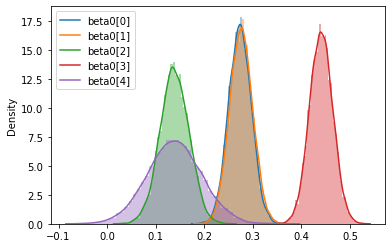

In [17]:
beta_index = 0

for k in range(n_k):
    sns.distplot(beta_samples[:,k,beta_index])
plt.legend(["beta0[%d]" % c for c in range(n_k)])
plt.show()

##### MSE for model

In [18]:
beta = beta_samples.mean(axis=0)
r = r_samples.mean(axis=0)
psi = (beta[k_test] @ X_test.T).diagonal()
d = dist.NegativeBinomial(torch.tensor(r), logits=torch.tensor(psi))
y_hat = np.array(d.mean)
# evaluate prediction accuracy
print("MSE:", sum((y_hat - y_test)**2)/len(y_hat))

MSE: 40.83038797486735


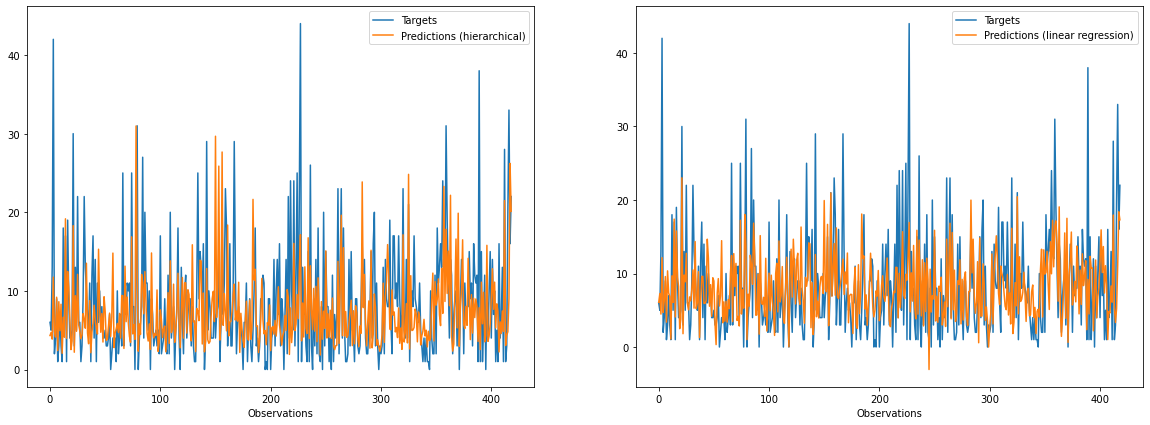

In [19]:
fig, ax = plt.subplots(1,2, figsize=(20,7))
ax[0].plot(y_test, label="Targets")
ax[0].plot(y_hat, label="Predictions (hierarchical)")
ax[0].legend()
ax[0].set_xlabel("Observations")

ax[1].plot(y_test, label="Targets")
ax[1].plot(y_hat_lreg, label="Predictions (linear regression)")
ax[1].legend()
ax[1].set_xlabel("Observations")
plt.show()